# ОПИСАНИЕ ПРОЕКТА
Оптимизируем процесс добычи золотой руды. Исходники - данные с параметрами добычи и очистки. 
Задача - предсказать коэффициент восстановления золота из золотосодержащей руды

Выполнение задани будет происходить тремя укрупненными блоками с выводами:
 1. Подготовка данных
 2. Анализ данных
 3. Построение модели
 4. Выбрать лучшую модель по метрике sMAPE

Технологический процесс описывается следующими понятиями:
- Rougher feed — исходное сырье
-  Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
Xanthate **— ксантогенат (промотер, или активатор флотации);
- Sulphate — сульфат (на данном производстве сульфид натрия);
- Depressant — депрессант (силикат натрия).
- Rougher process (англ. «грубый процесс») — флотация
- Rougher tails — отвальные хвосты
- Float banks — флотационная установка
- Cleaner process — очистка
- Rougher Au — черновой концентрат золота
- Final Au — финальный концентрат золота

Технологический процесс получение золота состоит из трех этапов:
- флотация
- первый этап очистки
- второй этап очистки

Возможные значения для блока [этап]:
- rougher — флотация
- primary_cleaner — первичная очистка
- secondary_cleaner — вторичная очистка
- final — финальные характеристики

Возможные значения для блока [тип_параметра]:
- input — параметры сырья
- output — параметры продукта
- state — параметры, характеризующие текущее состояние этапа
- calculation — расчётные характеристики

Параметры этапов:
air amount — объём воздуха
fluid levels — уровень жидкости
feed size — размер гранул сырья
feed rate — скорость подачи


# 1. Подготовка данных

In [189]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import itertools
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score, RandomizedSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


In [143]:
gold_train = pd.read_csv("gold_recovery_train.csv")
gold_test = pd.read_csv('gold_recovery_test.csv')
gold_full = pd.read_csv('gold_recovery_full.csv')

In [144]:
# посмотри на данные тезнологического процесса
data_list = [gold_full, gold_test, gold_train]
data_list_name = ['gold_full','gold_test', 'gold_full']
for data in data_list:
	display(data.head())
	display(data.info())
	display(data.describe())

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


None

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,22627.000000,22629.000000,22331.000000,22630.000000,20753.000000,22633.000000,22516.000000,22445.000000,22635.000000,21107.000000,...,22571.000000,22587.000000,22608.000000,22607.000000,22615.000000,22615.000000,22615.000000,22616.000000,22597.000000,22615.000000
mean,4.781559,9.095308,8.640317,40.001172,67.447488,8.923690,2.488252,9.523632,2.827459,140.277672,...,18.205125,-499.878977,14.356474,-476.532613,14.883276,-503.323288,11.626743,-500.521502,17.976810,-519.361465
std,2.030128,3.230797,3.785035,13.398062,11.616034,3.517917,1.189407,4.079739,1.262834,49.919004,...,6.560700,80.273964,5.655791,93.822791,6.372811,72.925589,5.757449,78.956292,6.636203,75.477151
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000003,...,0.000000,-799.920713,0.000000,-800.836914,-0.423260,-799.741097,0.427084,-800.258209,-0.079426,-810.473526
25%,4.018525,8.750171,7.116799,42.383721,63.282393,7.684016,1.805376,8.143576,2.303108,110.177081,...,14.095940,-500.896232,10.882675,-500.309169,10.941299,-500.628697,8.037533,-500.167897,13.968418,-500.981671
50%,4.953729,9.914519,8.908792,44.653436,68.322258,9.484369,2.653001,10.212998,2.913794,141.330501,...,18.007326,-499.917108,14.947646,-499.612292,14.859117,-499.865158,10.989756,-499.951980,18.004215,-500.095463
75%,5.862593,10.929839,10.705824,46.111999,72.950836,11.084557,3.287790,11.860824,3.555077,174.049914,...,22.998194,-498.361545,17.977502,-400.224147,18.014914,-498.489381,14.001193,-499.492354,23.009704,-499.526388
max,16.001945,17.031899,19.615720,53.611374,100.000000,19.552149,6.086532,22.861749,9.789625,274.409626,...,60.000000,-127.692333,31.269706,-6.506986,63.116298,-244.483566,39.846228,-120.190931,54.876806,-29.093593


,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

None

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5554.000000,5572.000000,5856.000000,5690.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,...,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000
mean,170.515243,8.482873,7.264651,1.321420,1481.990241,-509.057796,1486.908670,-511.743956,1468.495216,-509.741212,...,15.636031,-516.266074,13.145702,-476.338907,12.308967,-512.208126,9.470986,-505.017827,16.678722,-512.351694
std,49.608602,3.353105,0.611526,0.693246,310.453166,61.339256,313.224286,67.139074,309.980748,62.671873,...,4.660835,62.756748,4.304086,105.549424,3.762827,58.864651,3.312471,68.785898,5.404514,69.919839
min,0.000103,0.000031,5.650000,0.000003,0.000000,-799.773788,0.000000,-800.029078,0.000000,-799.995127,...,0.000000,-799.798523,0.000000,-800.836914,-0.223393,-799.661076,0.528083,-800.220337,-0.079426,-809.859706
25%,143.340022,6.411500,6.885625,0.888769,1497.190681,-500.455211,1497.150234,-500.936639,1437.050321,-501.300441,...,12.057838,-501.054741,11.880119,-500.419113,10.123459,-500.879383,7.991208,-500.223089,13.012422,-500.833821
50%,176.103893,8.023252,7.259333,1.183362,1554.659783,-499.997402,1553.268084,-500.066588,1546.160672,-500.079537,...,17.001867,-500.160145,14.952102,-499.644328,12.062877,-500.047621,9.980774,-500.001338,16.007242,-500.041085
75%,207.240761,10.017725,7.650000,1.763797,1601.681656,-499.575313,1601.784707,-499.323361,1600.785573,-499.009545,...,18.030985,-499.441529,15.940011,-401.523664,15.017881,-499.297033,11.992176,-499.722835,21.009076,-499.395621
max,274.409626,40.024582,15.500000,5.433169,2212.432090,-57.195404,1975.147923,-142.527229,1715.053773,-150.937035,...,30.051797,-401.565212,31.269706,-6.506986,25.258848,-244.483566,14.090194,-126.463446,26.705889,-29.093593


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


None

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,16788.000000,16788.000000,16490.000000,16789.000000,15339.000000,16794.000000,16677.000000,16715.000000,16794.000000,15553.000000,...,16731.000000,16747.000000,16768.000000,16767.000000,16775.000000,16775.000000,16775.000000,16776.000000,16757.000000,16775.000000
mean,4.716907,9.113559,8.301123,39.467217,67.213166,8.757048,2.360327,9.303932,2.687512,129.479789,...,19.101874,-494.164481,14.778164,-476.600082,15.779488,-500.230146,12.377241,-498.956257,18.429208,-521.801826
std,2.096718,3.389495,3.825760,13.917227,11.960446,3.634103,1.215576,4.263208,1.272757,45.386931,...,6.883163,84.803334,5.999149,89.381172,6.834703,76.983542,6.219989,82.146207,6.958294,77.170888
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000003,...,0.000000,-799.920713,0.000000,-800.021781,-0.423260,-799.741097,0.427084,-800.258209,0.024270,-810.473526
25%,3.971262,8.825748,6.939185,42.055722,62.625685,7.610544,1.641604,7.870275,2.172953,103.064021,...,14.508299,-500.837689,10.741388,-500.269182,10.977713,-500.530594,8.925586,-500.147603,13.977626,-501.080595
50%,4.869346,10.065316,8.557228,44.498874,67.644601,9.220393,2.453690,10.021968,2.781132,131.783108,...,19.986958,-499.778379,14.943933,-499.593286,15.998340,-499.784231,11.092839,-499.933330,18.034960,-500.109898
75%,5.821176,11.054809,10.289741,45.976222,72.824595,10.971110,3.192404,11.648573,3.416936,159.539839,...,24.983961,-494.648754,20.023751,-400.137948,20.000701,-496.531781,15.979467,-498.418000,24.984992,-499.565540
max,16.001945,17.031899,18.124851,53.611374,100.000000,19.552149,6.086532,22.317730,9.789625,251.999948,...,60.000000,-127.692333,28.003828,-71.472472,63.116298,-275.073125,39.846228,-120.190931,54.876806,-39.784927


In [145]:
#Выведем столбцы, которых нет в тестовой выборке:

set(gold_full.columns) - set(gold_test.columns)

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

В тестовой выборке отсутствуют столбцы с целевым признаком (rougher.output.recovery, final.output.recovery), а также все признаки, влияющие на целевые (выходные концентрации веществ после каждого этапа, а также столбцы calculation с расчетными характеристиками). Эти признаки тесно связаны с целевыми, и модель не должна их знать заранее, чтобы корректно сделать прогноз.

Проверим, что эффективность обогащения чернового концентрата rougher.output.recovery рассчитана правильно. Напишем для этого функцию recovery(C, F, T), в которой:

C — доля золота в концентрате после флотации/очистки;
F — доля золота в сырье/концентрате до флотации/очистки;
T — доля золота в отвальных хвостах после флотации/очистки.

In [146]:
# функция для проверки эффективности
def recovery(C, F, T):
    return C * (F - T) / (F * (C - T)) * 100  
#Вычислите её на обучающей выборке для признака rougher.output.recovery 
# Найдем MAE между нашими расчётами и значением признака при этом для корректности временно удалим пропуска в стобцах


In [147]:
gold_train_notnan = gold_train.dropna(subset=['rougher.output.concentrate_au', 'rougher.input.feed_au',
                                              'rougher.output.tail_au', 'rougher.output.recovery'])

In [148]:
gold_train_notnan['rougher_recovery_train'] = recovery(gold_train_notnan['rougher.output.concentrate_au'], gold_train_notnan['rougher.input.feed_au'], gold_train_notnan['rougher.output.tail_au'])

In [149]:
mae_rougher_recovery = mean_absolute_error(gold_train_notnan['rougher.output.recovery'],
                                           gold_train_notnan['rougher_recovery_train'])
print('MAE = ', mae_rougher_recovery)

MAE =  9.303415616264301e-15


МАЕ свидетельствует о верности расчет коэф. обогощения

Предобработка данных

		Посмотрим на количество пропусков по всем DF

In [150]:
for data in data_list:
	display(data.isna().sum())

date                                            0
final.output.concentrate_ag                    89
final.output.concentrate_pb                    87
final.output.concentrate_sol                  385
final.output.concentrate_au                    86
                                             ... 
secondary_cleaner.state.floatbank5_a_level    101
secondary_cleaner.state.floatbank5_b_air      101
secondary_cleaner.state.floatbank5_b_level    100
secondary_cleaner.state.floatbank6_a_air      119
secondary_cleaner.state.floatbank6_a_level    101
Length: 87, dtype: int64

date                                            0
primary_cleaner.input.sulfate                 302
primary_cleaner.input.depressant              284
primary_cleaner.input.feed_size                 0
primary_cleaner.input.xanthate                166
primary_cleaner.state.floatbank8_a_air         16
primary_cleaner.state.floatbank8_a_level       16
primary_cleaner.state.floatbank8_b_air         16
primary_cleaner.state.floatbank8_b_level       16
primary_cleaner.state.floatbank8_c_air         16
primary_cleaner.state.floatbank8_c_level       16
primary_cleaner.state.floatbank8_d_air         16
primary_cleaner.state.floatbank8_d_level       16
rougher.input.feed_ag                          16
rougher.input.feed_pb                          16
rougher.input.feed_rate                        40
rougher.input.feed_size                        22
rougher.input.feed_sol                         67
rougher.input.feed_au                          16
rougher.input.floatbank10_sulfate             257


date                                            0
final.output.concentrate_ag                    72
final.output.concentrate_pb                    72
final.output.concentrate_sol                  370
final.output.concentrate_au                    71
                                             ... 
secondary_cleaner.state.floatbank5_a_level     85
secondary_cleaner.state.floatbank5_b_air       85
secondary_cleaner.state.floatbank5_b_level     84
secondary_cleaner.state.floatbank6_a_air      103
secondary_cleaner.state.floatbank6_a_level     85
Length: 87, dtype: int64

	Из условия известно, что данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи. Воспользуемся KNNImputer из sklearn.impute, заполняющий пропуски средним от указанных соседних значений.

In [151]:
from sklearn.impute import KNNImputer

In [152]:
imputer = KNNImputer(n_neighbors=2)
gold_train.loc[:, 'final.output.concentrate_ag': 'secondary_cleaner.state.floatbank6_a_level'] = (
    imputer.fit_transform(gold_train.loc[:, 'final.output.concentrate_ag': 'secondary_cleaner.state.floatbank6_a_level']))

Приведем столбец date к формату даты и используем его в качестве индексов:

In [153]:
gold_train['date'] = pd.to_datetime(gold_train['date'], format='%Y-%m-%d %H:%M:%S')
gold_train = gold_train.set_index(['date'])

In [154]:
gold_test['date'] = pd.to_datetime(gold_test['date'], format='%Y-%m-%d %H:%M:%S')
gold_test = gold_test.set_index(['date'])

In [155]:
imputer = KNNImputer(n_neighbors=2)
gold_test.loc[:, gold_test.columns != 'date' ] = imputer.fit_transform(gold_test.loc[:, gold_test.columns != 'date'])

In [156]:
gold_full['date'] = pd.to_datetime(gold_full['date'], format='%Y-%m-%d %H:%M:%S')
gold_full = gold_full.set_index(['date'])

In [157]:
imputer = KNNImputer(n_neighbors=2)
gold_full.loc[:, gold_full.columns != 'date' ] = imputer.fit_transform(gold_full.loc[:, gold_full.columns != 'date' ])

In [158]:
for data in gold_full, gold_test, gold_train:
	display(data.isna().sum().sum())

0

0

0

Проверим есть ли нули и удалим их

In [159]:
def count_null (data_name):
	null_r = data_name[data_name['rougher.output.recovery'] == 0]['rougher.output.recovery'].count()
	null_f = data_name[data_name['final.output.recovery'] == 0]['final.output.recovery'].count()
	print(null_r, null_f)
	return

In [160]:
count_null(gold_train)

348 92


In [161]:
gold_train = gold_train.drop(gold_train[gold_train['rougher.output.recovery'] == 0].index)
gold_train = gold_train.drop(gold_train[gold_train['final.output.recovery'] == 0].index)


ВЫВОДЫ:
Данные предобработаны для дальнейшего анализа и построения моделей.
эффективность обогащения рассчитана правильно. MAE между нашими расчётами и значением признака одинаковы. Т.е. смело можно использовать данные из таблицы
Проанализированы признаки, недоступные в тестовой выборке. Эти данные отсутствуют на момент прогноза, т.к. замеряются и/или рассчитываются значительно позже output — параметры продукта

2. АНАЛИЗ ДАННЫХ

Отразим изменение концентрации метанолв (золото, серебро и свинец) на различных этапах очистки

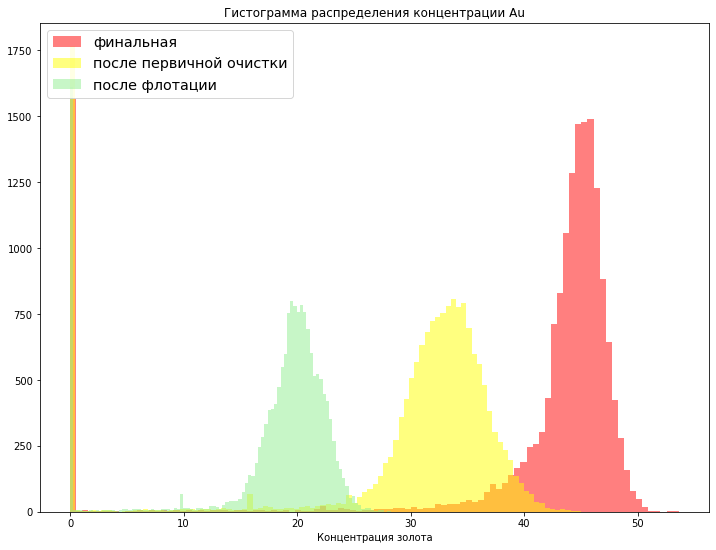

In [163]:

plt.figure(figsize=[12,9])

plt.hist(gold_train['final.output.concentrate_au'], bins=100, label = 'финальная', alpha=0.5, color='red')
plt.hist(gold_train['primary_cleaner.output.concentrate_au'], bins=100, label = 'после первичной очистки',
                                                                                alpha=0.5, color='yellow')
plt.hist(gold_train['rougher.output.concentrate_au'], bins=100, label = 'после флотации', alpha=0.5,
                                                                                       color='lightgreen')

plt.xlabel('Концентрация золота')

plt.legend(loc='upper left', fontsize='x-large')

plt.title('Гистограмма распределения концентрации Au')
plt.show()


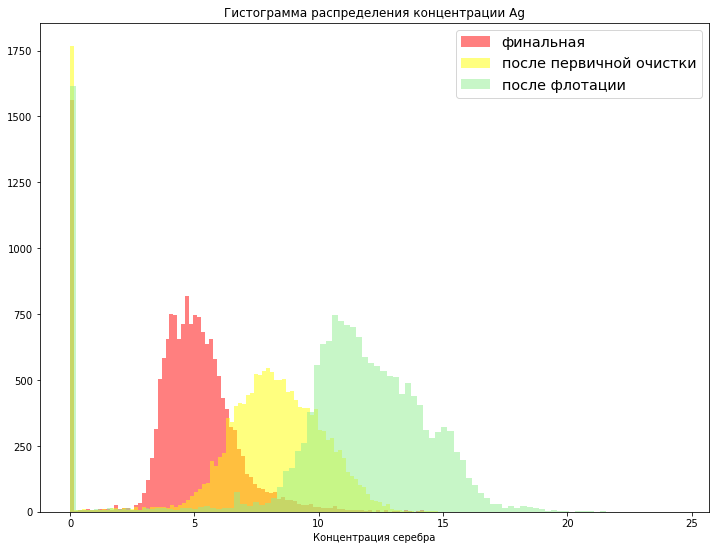

In [164]:
#Концентрация золота увеличивается с каждым этапом.

plt.figure(figsize=[12,9])

plt.hist(gold_train['final.output.concentrate_ag'], bins=100, label = 'финальная', alpha=0.5, color='red')
plt.hist(gold_train['primary_cleaner.output.concentrate_ag'], bins=100, label = 'после первичной очистки',
                                                                                alpha=0.5, color='yellow')
plt.hist(gold_train['rougher.output.concentrate_ag'], bins=100, label = 'после флотации', alpha=0.5,
                                                                                       color='lightgreen')

plt.xlabel('Концентрация серебра')

plt.legend(loc='upper right', fontsize='x-large')

plt.title('Гистограмма распределения концентрации Ag')
plt.show()

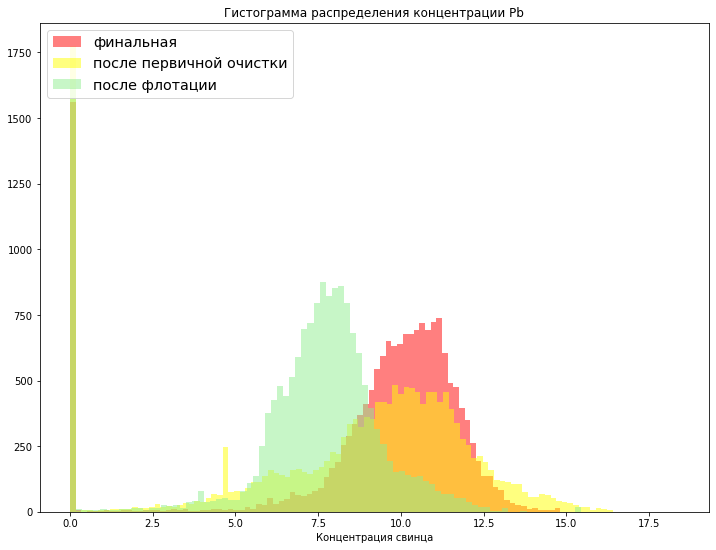

In [165]:
#Концентрация серебра понижается с каждым этапом очистки. Так как целью технологического процесса является получение золота, то менее благородные металлы удаляются.
plt.figure(figsize=[12,9])

plt.hist(gold_train['final.output.concentrate_pb'], bins=100, label = 'финальная', alpha=0.5, color='red')
plt.hist(gold_train['primary_cleaner.output.concentrate_pb'], bins=100, label = 'после первичной очистки',
                                                                                alpha=0.5, color='yellow')
plt.hist(gold_train['rougher.output.concentrate_pb'], bins=100, label = 'после флотации', alpha=0.5,
                                                                                       color='lightgreen')

plt.xlabel('Концентрация свинца')

plt.legend(loc='upper left', fontsize='x-large')

plt.title('Гистограмма распределения концентрации Pb')
plt.show()

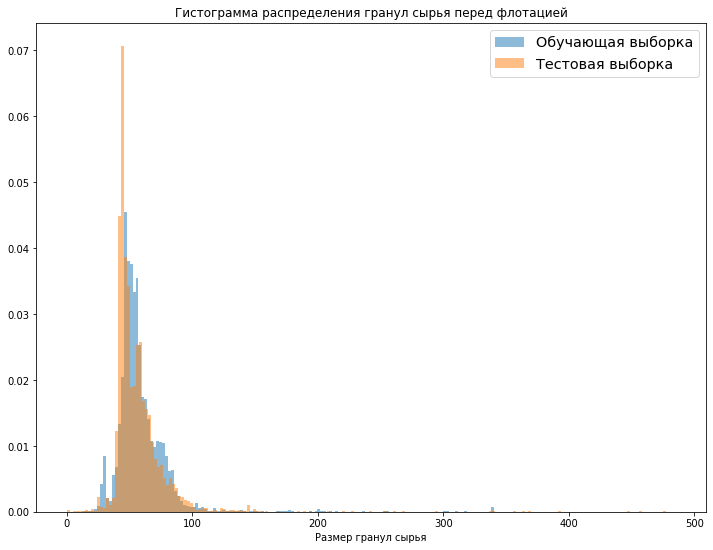

In [166]:
#Концентрация свинца повышается после флотации до первичной очистки. Далее практически не меняется.

#Сравним размеры гранул сырья на обучающей и тестовой выборках:
plt.figure(figsize=[12,9])

plt.hist(gold_train['rougher.input.feed_size'], bins=200, density=True, label = 'Обучающая выборка', alpha=0.5)
plt.hist(gold_test['rougher.input.feed_size'], bins=200, density=True, label = 'Тестовая выборка', alpha=0.5)

plt.xlabel('Размер гранул сырья')

plt.legend(loc='upper right', fontsize='x-large')

plt.title('Гистограмма распределения гранул сырья перед флотацией')
plt.show()


<Figure size 864x648 with 0 Axes>

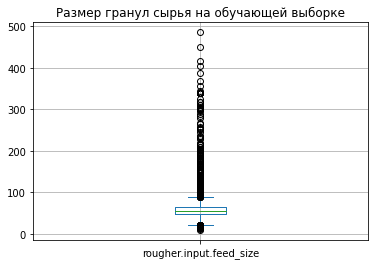

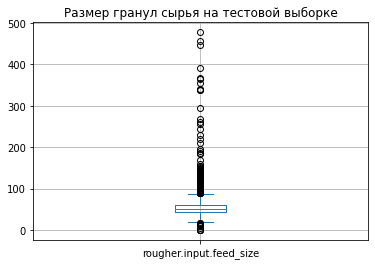

In [167]:
#Распределения похожи на нормальные со смещением влево. Взглянем на боксплоты:
plt.figure(figsize=[12,9])

gold_train.plot(y='rougher.input.feed_size', kind='box', title='Размер гранул сырья на обучающей выборке',
                                                                legend=False, grid=True)
gold_test.plot(y='rougher.input.feed_size', kind='box', title='Размер гранул сырья на тестовой выборке',
                                                                legend=False, grid=True)

plt.show()

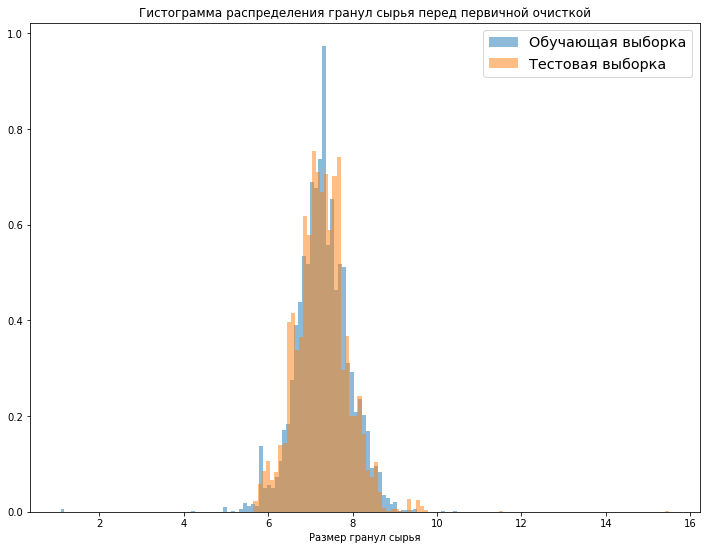

In [168]:
#У обоих распределений тяжелые "хвосты", но едва ли их можно назвать выбросами. Удалять ничего не будем, так как это реальный технологический процесс, который не всегда подчиняется нормальным законам. Посмотрим на гистограмму размеров гранул сырья перед первичной очисткой.
plt.figure(figsize=[12,9])

plt.hist(gold_train['primary_cleaner.input.feed_size'], density=True, bins=100, label = 'Обучающая выборка',
                                                                                                  alpha=0.5)
plt.hist(gold_test['primary_cleaner.input.feed_size'], density=True, bins=100, label = 'Тестовая выборка',
                                                                                                  alpha=0.5)

plt.xlabel('Размер гранул сырья')

plt.legend(loc='upper right', fontsize='x-large')

plt.title('Гистограмма распределения гранул сырья перед первичной очисткой')
plt.show()

<Figure size 864x648 with 0 Axes>

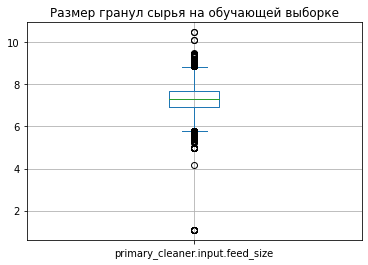

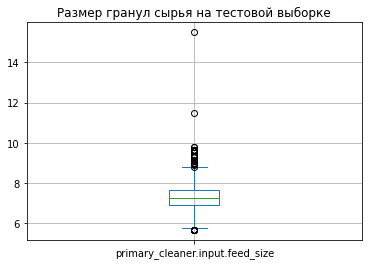

In [169]:
plt.figure(figsize=[12,9])

gold_train.plot(y='primary_cleaner.input.feed_size', kind='box', title='Размер гранул сырья на обучающей выборке',
                                                                legend=False, grid=True)
gold_test.plot(y='primary_cleaner.input.feed_size', kind='box', title='Размер гранул сырья на тестовой выборке',
                                                                legend=False, grid=True)

plt.show()

Распределения гранул сырья перед первичной очисткой похожи на нормальные, значимых отличий нет.

Теперь исследуем суммарную концентрацию всех веществ на разных этапах технологического процесса. Sol брать в расчет не будем, так как скорее всего, это какой-то раствор.

In [170]:
final_output_concentrate_sum_train = (gold_train['final.output.concentrate_au'] + 
                                      gold_train['final.output.concentrate_ag'] + 
                                      gold_train['final.output.concentrate_pb'])

primary_cleaner_output_concentrate_sum_train = (gold_train['primary_cleaner.output.concentrate_au'] + 
                                                gold_train['primary_cleaner.output.concentrate_ag'] + 
                                                gold_train['primary_cleaner.output.concentrate_pb'])

rougher_output_concentrate_sum_train = (gold_train['rougher.output.concentrate_au'] + 
                                        gold_train['rougher.output.concentrate_ag'] + 
                                        gold_train['rougher.output.concentrate_pb'])

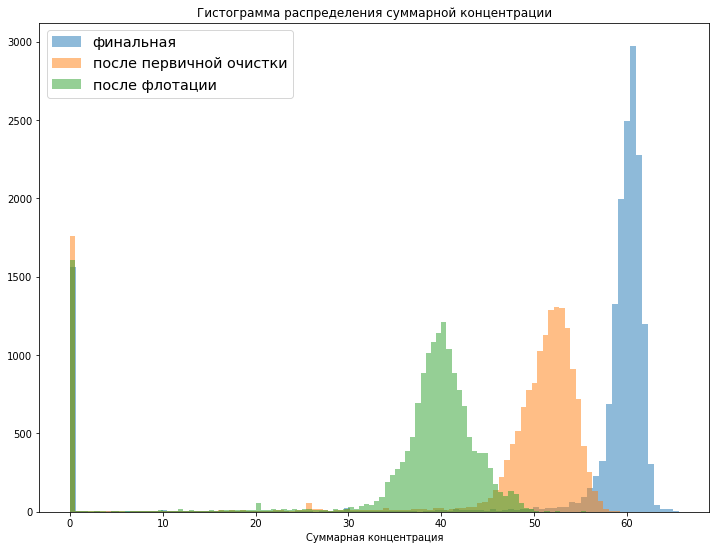

In [171]:
plt.figure(figsize=[12,9])

plt.hist(final_output_concentrate_sum_train, bins=100, label = 'финальная', alpha=0.5)
plt.hist(primary_cleaner_output_concentrate_sum_train, bins=100, label = 'после первичной очистки', alpha=0.5)
plt.hist(rougher_output_concentrate_sum_train, bins=100, label = 'после флотации', alpha=0.5)

plt.xlabel('Суммарная концентрация')

plt.legend(loc='upper left', fontsize='x-large')

plt.title('Гистограмма распределения суммарной концентрации')
plt.show()

На гистограмме суммарных концентраций видим нулевые значения после первичной очистки. Посмотрим поближе:

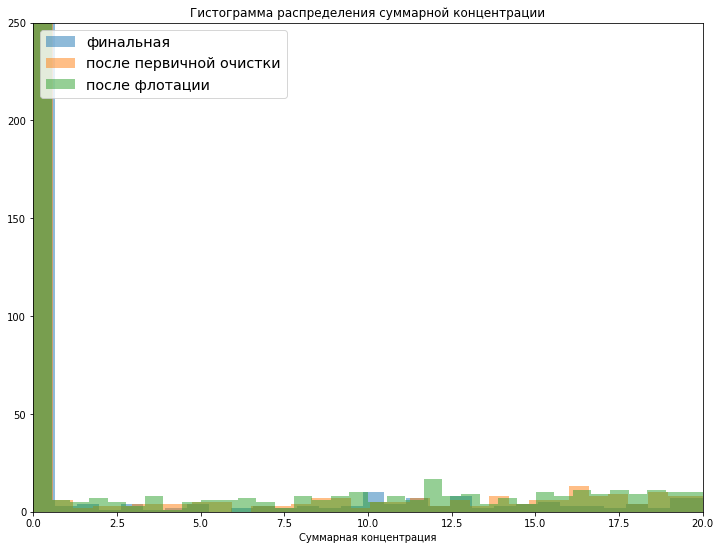

In [172]:
plt.figure(figsize=[12,9])

plt.hist(final_output_concentrate_sum_train, bins=100, label = 'финальная', alpha=0.5)
plt.hist(primary_cleaner_output_concentrate_sum_train, bins=100, label = 'после первичной очистки', alpha=0.5)
plt.hist(rougher_output_concentrate_sum_train, bins=100, label = 'после флотации', alpha=0.5)

plt.xlabel('Суммарная концентрация')
plt.xlim(0, 20)
plt.ylim(0, 250)

plt.legend(loc='upper left', fontsize='x-large')

plt.title('Гистограмма распределения суммарной концентрации')
plt.show()

Вероятно, нулевые значений суммарных концентраций после первичной очистки оказались результатом сбоя технологического процесса и являются аномалиями. Так как целью исследования является золото, удалим нулевые значения primary_cleaner.output.concentrate_au из обучающей выборки.

In [173]:
df_train= gold_train[(gold_train['rougher.input.feed_au'] !=0) & 
         (gold_train['rougher.output.concentrate_au'] !=0) &
         (gold_train['primary_cleaner.output.concentrate_au'] !=0) &
         (gold_train['final.output.concentrate_au'] != 0)]
df_train.head()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,122.270188,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,117.988169,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [175]:
#Разметим обучающие признаки и целевые признаки rougher.output.recovery и final.output.recovery df_test содержит все признаки для обучения

test_columns =  set(gold_test.columns)

In [176]:
df_train_features = df_train.loc[:, test_columns]
df_train_features
df_train_target = df_train.loc[:, ['rougher.output.recovery', 'final.output.recovery']]
df_train_target

,rougher.output.recovery,final.output.recovery
date,,
2016-01-15 00:00:00,87.107763,70.541216
2016-01-15 01:00:00,86.843261,69.266198
2016-01-15 02:00:00,86.842308,68.116445
2016-01-15 03:00:00,87.226430,68.347543
2016-01-15 04:00:00,86.688794,66.927016
...,...,...
2018-08-18 06:59:59,89.574376,73.755150
2018-08-18 07:59:59,87.724007,69.049291
2018-08-18 08:59:59,88.890579,67.002189


In [177]:
#Разделим features на rougher_features и final_features Для фильтрации по rougher используем метод .filter()
df_train_rougher_features = df_train_features.filter(regex='^rougher',axis=1)
df_train_rougher_features.head()

,rougher.state.floatbank10_b_air,rougher.input.floatbank11_sulfate,rougher.state.floatbank10_e_level,rougher.input.floatbank10_sulfate,rougher.input.feed_au,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_b_level,rougher.input.feed_sol,rougher.state.floatbank10_a_air,rougher.input.feed_rate,...,rougher.state.floatbank10_a_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_f_air,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_c_air,rougher.input.feed_size,rougher.state.floatbank10_d_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_level,rougher.input.feed_ag
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,1603.011353,11.836743,-455.462982,11.986616,6.486150,6.007990,-434.715027,36.808594,999.706909,523.546326,...,-404.066986,1404.472046,1416.354980,6.005818,1602.375000,55.486599,1598.937256,-442.204468,-451.294128,6.100378
2016-01-15 01:00:00,1600.754587,11.996163,-450.869848,11.971193,6.478583,6.005766,-449.953435,35.753385,1000.286398,525.290581,...,-400.065196,1399.227084,1399.719514,6.012594,1600.479580,57.278666,1600.527589,-449.830646,-449.953649,6.161113
2016-01-15 02:00:00,1599.337330,11.920305,-449.937588,11.920603,6.362222,6.197377,-450.008530,35.971630,999.719565,530.026610,...,-400.074028,1399.180945,1400.316682,6.204633,1599.672797,57.510649,1599.849325,-449.954491,-449.954185,6.116455
2016-01-15 03:00:00,1600.059442,11.692450,-450.030142,11.630094,6.118189,6.203177,-450.619948,36.862241,999.814770,542.590390,...,-400.200179,1400.943157,1400.234743,6.196578,1600.012842,57.792734,1597.725177,-449.910497,-450.130127,6.043309
2016-01-15 04:00:00,1600.208824,10.960521,-448.877187,10.957755,5.663707,6.198826,-449.599614,34.347666,999.678690,540.531893,...,-399.752729,1401.560902,1401.160227,6.194897,1600.357732,56.047189,1599.759049,-450.034364,-449.909799,6.060915


In [178]:
#final_features определяется разницей столбцов df_train_features и df_train_rougher_features

final_columns = set(df_train_features) - set(df_train_rougher_features)
df_train_final_features = df_train_features.loc[:, final_columns]
df_train_final_features.head()

,primary_cleaner.input.feed_size,primary_cleaner.state.floatbank8_a_level,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_b_level,primary_cleaner.input.sulfate,primary_cleaner.state.floatbank8_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank3_a_level,primary_cleaner.state.floatbank8_d_level,secondary_cleaner.state.floatbank4_a_level,...,primary_cleaner.state.floatbank8_d_air,secondary_cleaner.state.floatbank6_a_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,primary_cleaner.input.depressant,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,7.25,-498.912140,0.988759,-516.403442,127.092003,1549.775757,-498.310211,-495.262817,-493.428131,-502.488007,...,1554.367432,-605.841980,9.925633,-498.526489,-500.470978,14.151341,10.128295,-504.715942,-499.340973,14.016835
2016-01-15 01:00:00,7.25,-500.904965,1.002663,-499.865889,125.629232,1576.166671,-500.169983,-500.085473,-498.931665,-505.503262,...,1574.479259,-599.787184,10.039245,-499.989656,-500.582168,13.998353,10.296251,-501.331529,-499.446897,13.992281
2016-01-15 02:00:00,7.25,-499.997791,0.991265,-500.607762,123.819808,1601.556163,-500.129135,-499.442343,-499.827444,-502.520901,...,1599.541515,-601.427363,10.070913,-499.929616,-500.517572,14.028663,11.316280,-501.133383,-499.901982,14.015015
2016-01-15 03:00:00,7.25,-500.951778,0.996739,-499.677094,122.270188,1599.968720,-499.201640,-500.008812,-500.052575,-500.857308,...,1600.449520,-599.996129,9.970366,-499.176749,-500.255908,14.005551,11.322140,-501.193686,-499.944710,14.036510
2016-01-15 04:00:00,7.25,-498.975456,1.009869,-500.323246,117.988169,1601.339707,-501.686727,-500.083811,-500.593010,-499.838632,...,1602.649541,-601.496691,9.925709,-500.279091,-500.356035,13.996647,11.913613,-501.053894,-499.990309,14.027298


In [179]:
#Тоже самое для тестовой выборке df_test:

df_test_rougher_features = gold_test.filter(regex='^rougher',axis=1)
df_test_rougher_features.head()

,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,...,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level
date,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,...,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807
2016-09-01 01:59:59,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,...,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514
2016-09-01 02:59:59,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,...,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340
2016-09-01 03:59:59,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.515277,5.803657,...,1251.322675,-398.655289,1250.493702,-399.746728,1199.398691,-397.503052,1001.930679,-400.437573,950.735324,-399.802986
2016-09-01 04:59:59,11.327427,4.767383,488.248117,63.315324,41.269161,11.290425,13.607257,5.738081,13.650053,5.739634,...,1304.658848,-399.511519,1306.455515,-399.050685,1248.699349,-400.876894,1058.839106,-398.988239,949.645313,-399.277632


In [181]:
df_test_final_features = gold_test.loc[:, final_columns]
df_test_final_features.info()
#Удалим аномальные 0 из df_full

df_full = gold_full[(gold_full['rougher.input.feed_au'] !=0) & 
         (gold_full['rougher.output.concentrate_au'] !=0) &
         (gold_full['primary_cleaner.output.concentrate_au'] !=0) &
         (gold_full['final.output.concentrate_au'] != 0)]
df_full.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5856 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 30 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.feed_size             5856 non-null   float64
 1   primary_cleaner.state.floatbank8_a_level    5856 non-null   float64
 2   primary_cleaner.input.xanthate              5856 non-null   float64
 3   primary_cleaner.state.floatbank8_b_level    5856 non-null   float64
 4   primary_cleaner.input.sulfate               5856 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5856 non-null   float64
 6   secondary_cleaner.state.floatbank5_a_level  5856 non-null   float64
 7   secondary_cleaner.state.floatbank3_a_level  5856 non-null   float64
 8   primary_cleaner.state.floatbank8_d_level    5856 non-null   float64
 9   secondary_cleaner.state.floatbank4_a_level  5856 

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,122.270188,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,117.988169,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [182]:
#Используя ощищенную от 0 df_full запишем df_test_full:

df_test_full = pd.DataFrame(data=df_full, index=gold_test.index)
df_test_full.dropna(inplace=True)
df_test_full.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5259 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         5259 non-null   float64
 1   final.output.concentrate_pb                         5259 non-null   float64
 2   final.output.concentrate_sol                        5259 non-null   float64
 3   final.output.concentrate_au                         5259 non-null   float64
 4   final.output.recovery                               5259 non-null   float64
 5   final.output.tail_ag                                5259 non-null   float64
 6   final.output.tail_pb                                5259 non-null   float64
 7   final.output.tail_sol                               5259 non-null   float64
 8   final.output.tail_au                      

In [183]:
#Назначим целевые признаки в df_test_target

df_test_target = df_test_full.loc[:, ['rougher.output.recovery', 'final.output.recovery']]
df_test_target.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5259 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   rougher.output.recovery  5259 non-null   float64
 1   final.output.recovery    5259 non-null   float64
dtypes: float64(2)
memory usage: 123.3 KB


In [184]:
#Так как в features и target размеры ДатаФреймов разные из за 0 значений, приведем к одной размерности, используя индексы df_test_full.index

df_test_rougher_features = pd.DataFrame(data=df_test_rougher_features, index=df_test_full.index)
df_test_final_features = pd.DataFrame(data=df_test_final_features, index=df_test_full.index)
df_test_rougher_features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5259 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 22 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   rougher.input.feed_ag               5259 non-null   float64
 1   rougher.input.feed_pb               5259 non-null   float64
 2   rougher.input.feed_rate             5259 non-null   float64
 3   rougher.input.feed_size             5259 non-null   float64
 4   rougher.input.feed_sol              5259 non-null   float64
 5   rougher.input.feed_au               5259 non-null   float64
 6   rougher.input.floatbank10_sulfate   5259 non-null   float64
 7   rougher.input.floatbank10_xanthate  5259 non-null   float64
 8   rougher.input.floatbank11_sulfate   5259 non-null   float64
 9   rougher.input.floatbank11_xanthate  5259 non-null   float64
 10  rougher.state.floatbank10_a_air     5259 non-null   float64
 11  rougher

In [185]:
df_test_final_features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5259 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 30 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.feed_size             5259 non-null   float64
 1   primary_cleaner.state.floatbank8_a_level    5259 non-null   float64
 2   primary_cleaner.input.xanthate              5259 non-null   float64
 3   primary_cleaner.state.floatbank8_b_level    5259 non-null   float64
 4   primary_cleaner.input.sulfate               5259 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5259 non-null   float64
 6   secondary_cleaner.state.floatbank5_a_level  5259 non-null   float64
 7   secondary_cleaner.state.floatbank3_a_level  5259 non-null   float64
 8   primary_cleaner.state.floatbank8_d_level    5259 non-null   float64
 9   secondary_cleaner.state.floatbank4_a_level  5259 

Вывод: в данном разделе была проанализирована концентрация веществ на разных этапах технологического процесса, найдены и удалены аномалии.

3. ПОСТРОЕНИЕ МОДЕЛЕЙ

Для того, чтобы отмаштабировать признаки, воспользуемся одним из методов масштабирования — стандартизации данных.
В sklearn есть отдельная структура для стандартизации данных — StandardScaler
Преобразуем данные функцией transform(). Напишем для этого функцию data_to_StandardScaler(data)

In [186]:
from sklearn.preprocessing import StandardScaler

In [187]:
def data_to_StandardScaler(data):
    sc = StandardScaler()
    data = sc.fit_transform(data)
    return data

In [188]:
df_train_rougher_features = data_to_StandardScaler(df_train_rougher_features)
df_train_final_features = data_to_StandardScaler(df_train_final_features)

df_test_rougher_features = data_to_StandardScaler(df_test_rougher_features)
df_test_final_features = data_to_StandardScaler(df_test_final_features)

Признаки:
df_train_rougher_features
df_train_final_features
df_test_rougher_features
df_test_final_features

Целевые признаки:
df_train_target['rougher.output.recovery'], df_train_target['final.output.recovery']
df_test_target['rougher.output.recovery'], df_test_target['final.output.recovery']

Сохраним модели в переменных:

In [190]:
linear_model = LinearRegression()
decision_tree_model = DecisionTreeRegressor(random_state=12345)
random_forest_model = RandomForestRegressor(random_state=12345)

Для подбора гиперпараметров импортируем GridSearchCV, для кросс-валидации при подборе гиперпараметров ShuffleSplit

In [191]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit

In [192]:
#Вызовем гиперпараметры модели для тюнинга, используя .get_params().keys():

decision_tree_model.get_params().keys()

dict_keys(['ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'random_state', 'splitter'])

In [193]:
#Создадим словарь гиперпараметров для решающего дерева:

parameters_grid = {
    'max_depth' : range(1,6),
    'min_samples_leaf': range(1,6),
    'min_samples_split': range(1,6)
}

In [194]:
#Стратегия кросс-валидации для подбора параметров:

cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=0)

In [195]:
#И создадим объект GridSearchCV

from sklearn.metrics import make_scorer

In [196]:
#Импортировали make_scorer из sklearn.metrics и напишем собственный оценщик sMAPE:

def sMAPE(predict, target):
    sMAPE = (abs(target - predict) / ((abs(target) + abs(predict)) / 2)).mean() * 100
    return sMAPE

score = make_scorer(sMAPE, greater_is_better=False)

In [197]:
grid_cv = GridSearchCV(decision_tree_model, parameters_grid, scoring=score, cv=cv)

In [198]:
#Запустим подбор параметров для rougher_features:

%%time
grid_cv.fit(df_train_rougher_features, df_train_target['rougher.output.recovery'])

UsageError: Line magic function `%%time` not found.
